In [1]:
# Imports
import pandas as pd
import numpy as np
import xarray as xr
import networkx as nx
from scipy.interpolate import griddata
from scipy.spatial import cKDTree, SphericalVoronoi
from scipy import sparse
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian
import matplotlib.pyplot as plt
import cartopy as cart
from datetime import datetime
import warnings
import pickle
import os
try:
    import stripy
except ImportError:
    print("Stripy is not available on this machine.")

Stripy is not available on this machine.


In [2]:
def get_cartesian(lon, lat, R=1, mode='rad', ):
    """
    Convert spherical coordinates to cartesian coordinates.
    
    Parameters
    ----------
    lon : float, np.array
        longitude coordinate(s)
    lat : float, np.array
        latitude coordinate(s)
    R : int, float
        radius of sphere
    mode : str
        Either 'rad' or 'deg', indicating whether coordinates are supplied
        in radians or degrees respectively.
        
    Returns
    -------
    x, y, z : (float, float, float)
        Cartesian coordinates
    """
    if mode=='deg':
        lat, lon = np.radians(lat), np.radians(lon)
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x, y, z

In [152]:
def lonlat_from_pset(pset, timedelta64=None):
    """
    Extract latitude and longitude data from particleSet.
    
    Parameters
    ----------
    pset : str
        string with path to ``parcels.ParticleSet`` output file
    timedelta64 : np.timedelta64
        relative timestamp to load data from pset at, relative to start time

    Returns
    -------
    lonlat_init
        np.array with initial longitude-latitude pairs
    lonlat_final
        np.array with final longitude-latitude pairs    
    """
    ds = xr.open_dataset(pset)
    lons = ds['lon'].data
    lats = ds['lat'].data
    ids = ds['traj'].data
    times = ds['time'].data

    if np.any(np.diff(times[:,0]).astype(bool)):
        warnings.warn("Not all starting times are equal. Behaviour may not be as expected.", Warning)
    if timedelta64:
        # Determine which trajectory idx to use for searchsorted, 
        # since it must contain timestamps in the last index.
        firstFullTrajectoryIdx = np.searchsorted(~np.isnat(times[:, -1]), True)
        # Find index at which trajectories shoudl be investigated
        final_tidx = np.searchsorted(times[firstFullTrajectoryIdx,:], 
                                     times[firstFullTrajectoryIdx,0] + timedelta64)
        if final_tidx == times.shape[1]:
            warnings.warn("`final_tidx` lies outside of time window. Choosing last index instead", Warning)
            final_tidx = times.shape[1]-1
    else:
        final_tidx = times.shape[1]-1
    lonlatInit = np.dstack((lons[:,0], lats[:,0]))
    lonlatFinal = np.dstack((lons[:,final_tidx], lats[:, final_tidx]))
    ds.close()
    return lonlatInit, lonlatFinal

In [153]:
class particles:
    """
    Basic instance of particles object has lists holding the latitudes and longitudes of its points.
    
    Attributes
    ----------
    lats : np.array
        list of latitudes (in degrees)
    lons : np.array
        list of longitudes (in degrees)
    lonlat : np.ndarray
        2D array holding pairs of latitude and longitude of each particle
    n : int
        number of gridpoints
    idx : np.ndarray
        index of each gridpoint
    _releaseTime : datetime
        release time of particles
    """
    def __init__(self, lons, lats, idx = None, releaseTime = None):
        assert len(lats) == len(lons), "lats and lons should be of equal size"
        self._releaseTime = releaseTime
        self.lons = lons
        self.lats = lats
        self.lonlat = np.dstack((lons, lats)) #First axis corresponds to time
        # idx should not be updated since this makes triangle points harder to track down
        if idx: 
            self.idx = idx
        else:
            self.idx = np.arange(self.n)
    
    @property
    def n(self):
        return self.lonlat.shape[1]
    
    @property
    def releaseTimes(self):
        if self._releaseTime:
            return [self._releaseTime for part in range(self.n)]
        else:
            pass
    
    @classmethod
    def from_regular_grid(cls, nlon, nlat, minLat=60., maxLat=90., minLon=-180, maxLon=180, **kwargs):
        """
        Grid construction by dividing latitude and longitude ranges into a discrete amount of points.
        
        Parameters
        ----------
        nlat : int
            number of latitudes.
        nlon : int
            number of longitudes.
        minLat : float
            minimum latitude of grid (southern boundary)
        maxLat : float
            maximum latitude of grid (northern boundary)
        minLon : float
            minimum longitude of grid (western boundary)
        maxLon : float
            maximum longitude of grid (eastern boundary)
        """
        lonRange = np.linspace(minLon, maxLon, nlon)
        latRange = np.linspace(minLat, maxLat, nlat)
        lon2D, lat2D = np.meshgrid(lonRange, latRange)
        return cls(lon2D.flatten(), lat2D.flatten(), **kwargs)
    
    @classmethod
    def from_pickle(cls, pickFile, lonKey='lons', latKey='lats', **kwargs):
        """
        Load longitudes and latitudes of particles from pickled dictionary
        
        Parameters
        ----------
        pickFile : str
            Path to pickled dictionary
        lonKey : str
            Key for longitudes in dictionary
        latKey : str
            Key for latitudes in dictionary
        """ 
        with open(pickFile, 'rb') as pickFile:
            lonlat_dict = pickle.load(pickFile)
            return cls(lonlat_dict[lonKey], lonlat_dict[latKey], **kwargs)
    
    def remove_on_land(self, fieldset):
        """
        Uses the fieldset.landMask to remove particles that are located on land (where u, v == 0 or -1)
        
        Parameters
        ----------
        fieldset : Parcels.FieldSet
            should have a landMask attribute (created by fieldSetter)
        """
        
        nBefore = self.n
        # Load landmask and initialize mask for particles on land 
        landMask = fieldset.landMask
        try:
            landMask = landMask.compute()
        except AttributeError:
            pass
        # Use scipy.interpolate.griddata to have particles adopt value of landmask from nearest neighbor
        if fieldset.U.grid.lon.ndim == 1:
            mesh = np.meshgrid(fieldset.U.grid.lon, fieldset.U.grid.lat)
            lonlatMask = griddata(np.dstack((mesh[0].flatten(), 
                                             mesh[1].flatten()))[0,:,:], 
                                  landMask.flatten(), 
                                  self.lonlat[0,:,:], 
                                  method='nearest')
        else: 
            lonlatMask = griddata(np.dstack((fieldset.U.grid.lon.flatten(), 
                                             fieldset.U.grid.lat.flatten()))[0,:,:], 
                                  landMask.flatten(), 
                                  self.lonlat[0,:,:], 
                                  method='nearest')
        self.lonlat = self.lonlat[:, ~lonlatMask, :]
        self.lons = self.lonlat[0, :, 0]
        self.lats = self.lonlat[0, :, 1]
        nAfter = self.n
        self.removedParticleCount = nBefore - nAfter
    
    def add_advected_from_pset(self, *args, **kwargs):
        """
        Add final particle locations by loading them from a pset. See `lonlat_from_pset()`.    
        """
        lonlatFinal = lonlat_from_pset(pset, *args, **kwargs)[1]
        self.lonlat = np.concatenate((self.lonlat, lonlat_final), axis=0)
    
    def show(self, tindex = 0, export = None, projection=None, **kwargs):
        """
        Create a plot of the particle locations in particles object.
        
        Parameters
        ----------
        tindex : int
            Index of lonlat pairs (0 is initial, 1 is final).
        export : str
            Name of exported figure. A directory 'figures' is created.
        """
        fig = plt.figure()
        if projection:
            ax = plt.axes(projection = projection)
        else:
            ax = plt.axes(projection = cart.crs.PlateCarree())
        ax.scatter(self.lonlat[tindex, :, 0], self.lonlat[tindex, :, 1], transform = cart.crs.Geodetic(), **kwargs)
        ax.add_feature(cart.feature.COASTLINE)
        if export:
            if not os.path.exists('figures'):
                os.makedirs('figures')
            if export[-4] == '.':
                plt.savefig(f'figures/{export}', dpi=300)
            else:
                plt.savefig(f'figures/{export}.png', dpi=300)
        return ax

In [225]:
class countBins:
    """
    Bins used for counting particles.

    Attributes
    ----------
    binType : str
        Indicates the type of bin: `regular` or `hexagonal`
    """
    
    def load_communities(self, comFile, parser = 'clu'):
        """
        Load communities determined by a community detection algorithm on a regular grid
        
        Parameters
        ----------
        comFile : str
            Filename of community file
        parser : str
            Parser to use
        """
        #----- START PARSERS -----#
        if parser == 'legacy':
            self.communityDF = pd.read_csv(comFile,  delimiter=" ").set_index('node')
        if parser == 'clu':
            with open(comFile) as cluFile:
                clu = cluFile.read().split('\n')
            self.codelength = float(clu[0].split(' ')[3])
            header = clu[1].split(' ')[1:]
            body = [line.split(' ') for line in clu[2:] if line is not '']
            self.communityDF = pd.DataFrame(body, columns=header).astype({"node" : 'int', 
                                                                          "module" : 'int', 
                                                                          "flow" : 'float' }).set_index("node")
        if parser == 'tree':
            """
            Not yet fully impelemented. Should have the option to investigate multiple tree levels
            """
            with open(comFile) as treeFile:
                tree = treeFile.read().split('\n')
            self.codelength = float(tree[0].split(' ')[3])
            header = tree[1].split(' ')[1:]
            body = [line.split(' ') for line in tree[2:] if line is not '']
            self.communityDF = pd.DataFrame(body, columns=header).drop(columns="name").rename(columns={'physicalId': 'node'})
            self.communityDF['rank'] = self.communityDF['path'].map(lambda a: a.split(":")[-1])
            self.communityDF['module'] = self.communityDF['path'].map(lambda a: a.split(":")[-2])
            self.communityDF = self.communityDF.astype({"node" : "int",  "module" : "int", "flow" : "float"}).set_index("node")
        #------ END PARSERS ------#
        communityID = -np.ones(self.n, dtype=int)
        communityFlow = -np.ones(self.n, dtype=float)
        if hasattr(self, 'oceanMask'):
            bindex = self.bindex[self.oceanMask]
        else:
            bindex = self.bindex
        assert self.communityDF.shape[0] == bindex.shape[0], "Number of nodes in `.clu` file must equal the amount of non-empty bins."
        for index, row in self.communityDF.iterrows():
            # -1 because counting in clu file starts at 1
            communityID[bindex[index-1]] = row['module'].astype(int)
            communityFlow[bindex[index-1]] = row['flow']

        self.communityID = np.ma.masked_equal(communityID, -1)
        self.communityFlow = np.ma.masked_equal(communityFlow, -1)
        
        self.communityIdx = {}
        for community in np.unique(self.communityID).data[np.unique(self.communityID).data != -1]:
            self.communityIdx[community] = {'bindex' : {},
                                            'oceanBindex' : {}}
            self.communityIdx[community]['bindex'] = self.bindex[self.communityID == community]
            nonZeroCommunityID = self.communityID.data[self.communityID.data != -1]
            self.communityIdx[community]['oceanBindex'] = np.arange(nonZeroCommunityID.size)[nonZeroCommunityID == community]

    def color_communities(self, colors=4):
        """Associate new colors to existing communities by using graph coloring.
        
        Parameters
        ----------
        num_colors : int
            Number of colors that will be used for coloring the map. Currently, if `num_colors` is less than or 
            equal to the maximum degree, `num_colors` is increased to maxDegree+1.

        Returns
        -------
        np.array
            Array containing new community IDs, corresponding to different colors.
        """
        num_colors=4
        try:
            self.communityNetwork = nx.Graph()
            for community in self.adjacencyDict:
                for neighbor in self.adjacencyDict[community]:
                    self.communityNetwork.add_edge(community, neighbor)
            # Remove self-loops
            self.communityNetwork.remove_edges_from(self.communityNetwork.selfloop_edges())
        except NameError:
            raise RuntimeError('The counting grid does not yet have an adjacency dictionary for determining the coloring of communities. Try calling the `find_adjacency()` method first.')
        self.colorMapping = nx.coloring.greedy_color(self.communityNetwork, strategy='largest_first')
        colorID = -np.ones(self.n, dtype=int)
        maxColor = max(list(self.colorMapping.values()))
        for i in range(len(self.communityID.flatten())):
            if not np.ma.is_masked(self.communityID.flatten()[i]):
                colorID[i] = self.colorMapping.get(self.communityID.flatten()[i], maxColor + 1)
        self.colorID = np.ma.masked_equal(colorID, -1).reshape(self.communityID.shape)
        return self.colorID
    
    def calculate_coherence_ratio(self, transMat):
        """
        Calculate the coherence ratio for each community.
        
        Parameters
        ----------
        transMat : transMat
            Transition matrix to calculate coherence ratios.
        
        Returns
        -------
        np.array
            Array containing the coherence ratio of the community that each bin is part of.
        """
        self.coherenceRatioDict = {}
        for community, idx in self.communityIdx.items():
            denom = np.sum(np.sum(transMat.counter[idx["oceanBindex"], :], axis=1))
            if denom != 0:
                self.coherenceRatioDict[community] = np.sum(np.sum(transMat.counter[idx["oceanBindex"], :][:, idx["oceanBindex"]], axis=1))/denom
        coherenceRatio = -np.ones(self.n, dtype=float)
        for i in range(len(self.communityID.flatten())):
            if not np.ma.is_masked(self.communityID.flatten()[i]):
                coherenceRatio[i] = self.coherenceRatioDict.get(self.communityID.flatten()[i], -1)
        self.coherenceRatio = np.ma.masked_equal(coherenceRatio, -1).reshape(self.communityID.shape)
        return self.coherenceRatio
    
    def calculate_global_coherence(self):
        """
        Calculate the global coherence ratio.
        
        Returns
        -------
        float
            Global coherence ratio        
        """
        assert hasattr(self, "coherenceRatio"), "Coherence ratios must be calculated first. Try calling the `calculate_coherence_ratio(transMat)` method."
        self.globalCoherenceRatio = self.coherenceRatio[~self.coherenceRatio.mask].mean()
        return self.globalCoherenceRatio
    
    def calculate_mixing(self, transMat):
        """
        Parameters
        ----------
        transMat : transMat
            Transition matrix to calculate mixing parameters.
        
        Returns
        -------
        np.array
            Array containing the mixing parameter of the community that each bin is part of.
        """
        self.mixingDict = {}
        for community, idx in self.communityIdx.items():
            subsetCounter = transMat.counter[idx["oceanBindex"], :][:, idx["oceanBindex"]]
            subsetSums = np.tile(subsetCounter.sum(axis=1), (subsetCounter.shape[1],1)).T
            R = np.divide(subsetCounter, subsetSums, out=np.zeros_like(subsetSums), where=subsetSums!=0)
            if R.shape[0] > 1: 
                self.mixingDict[community] = np.divide(-np.sum(R*np.log(R, out=np.zeros_like(R), where=R!=0)), R.shape[0]*np.log(R.shape[0]))
            else:
                self.mixingDict[community] = -1
        mixing = -np.ones(self.n, dtype=float)
        for i in range(len(self.communityID.flatten())):
            if not np.ma.is_masked(self.communityID.flatten()[i]):
                mixing[i] = self.mixingDict[self.communityID.flatten()[i]]
        self.mixing = np.ma.masked_equal(mixing, -1).reshape(self.communityID.shape)
        return self.mixing
    
    def calculate_global_mixing(self):
        """
        Calculate the global mixing parameter.
        
        Returns
        -------
        float
            Global mixing parameter      
        """
        assert hasattr(self, "mixing"), "Coherence ratios must be calculated first. Try calling the `calculate_coherence_ratio(transMat)` method."
        self.globalMixing = self.mixing[~self.mixing.mask].mean()
        return self.globalMixing
    
    def nComs(self, cutoff=0):
        """
        Returns number of communities larger than `cutoff`.
        """
        counts = np.unique(self.communityID, return_counts=True)[2]
        return np.sum(counts > cutoff)

In [226]:
class regularCountBins(countBins):
    def __init__(self, nlon, nlat, minLat=60., maxLat=90., minLon=-180, maxLon=180, **kwargs):
        """
        Grid construction by dividing latitude and longitude ranges into a discrete amount of points.
        
        Parameters
        ----------
        nlat : int
            number of latitudes.
        nlon : int
            number of longitudes.
        minLat : float
            minimum latitude of grid (southern boundary)
        maxLat : float
            maximum latitude of grid (northern boundary)
        minLon : float
            minimum longitude of grid (western boundary)
        maxLon : float
            maximum longitude of grid (eastern boundary)
        """
        self.binType = 'regular'
        dlat = (maxLat - minLat)/nlat
        dlon = (maxLon - minLon)/nlon
        lonOffset = dlon/2
        latOffset = dlat/2
        self.lonBounds = np.linspace(minLon, maxLon, nlon+1)
        self.latBounds = np.linspace(minLat, maxLat, nlat+1)
        lonCenters = np.linspace(minLon + lonOffset, maxLon - lonOffset, nlon)
        latCenters = np.linspace(minLat + latOffset, maxLat - latOffset, nlat)
        self.lonCenters2D, self.latCenters2D = np.meshgrid(lonCenters, latCenters)
        self.lonIdx2D, self.latIdx2D = np.meshgrid(np.arange(nlon), np.arange(nlat))
        self.gridShape = self.lonIdx2D.shape
        self.bindex = (np.arange(len(self.lonIdx2D.flatten())))
        self.bindex2D = self.bindex.reshape(self.gridShape)
    
    @property
    def n(self):
        return len(self.bindex)
    
    def particle_count(self, particles, tindex=0):
        count = np.histogram2d(particles.lonlat[tindex,:,0], particles.lonlat[tindex,:,1], bins=[self.lonBounds, self.latBounds])[0]
        if tindex == 0:
            self.initCount = count
        return count
    
    def find_adjacency(self, mode='Neumann'):
        """
        Create an adjacency list: for each node (grid cell), determine which nodes are bordering this node.
        
        Parameters
        ----------
        mode : string
            Either 'Neumann' or 'Moore'. Indicates the pixel neighborhood used for determining
            neighbors. The Von Neumann neighborhood only considers pixels touching the edges to
            be neighbors, while the Moore neighborhood also considers pixels touching the 
            corners.

        Returns
        -------
        dict
            Containing keys corresponding to community IDs and values being `set` objects
            containing IDs of bordering communities.
        """
        assert self.binType == "regular", "Bin type must be regular."
        # Construct empty adjacency dictionary
        # Using dictionary so that labels coincide labels created by InfoMap, rather than being 
        # indices, which might not coincide with labels.
        communityID2D = self.communityID.reshape(self.gridShape)
        self.adjacencyDict = {}
        # Iterate over all cells
        for i in range(self.gridShape[0]):
            for j in range(self.gridShape[1]):
                # Save current community in variable
                currentCommunity = int(communityID2D[i,j])
                # If the current community doesn't have a key and value yet, add an empty
                # set to the dictionary, with the key being the community ID.
                if currentCommunity not in self.adjacencyDict:
                    self.adjacencyDict[currentCommunity] = set()
                self.adjacencyDict[currentCommunity].add(int(communityID2D[i, j+1//self.gridShape[1]]))
                self.adjacencyDict[currentCommunity].add(int(communityID2D[i, j-1]))
                # Careful at northern and southern boundaries. 
                if i<self.gridShape[0]-1:
                    self.adjacencyDict[currentCommunity].add(int(communityID2D[i+1, j]))
                    if mode == 'Moore':
                        self.adjacencyDict[currentCommunity].add(int(communityID2D[i+1, j+1//self.gridShape[1]]))
                        self.adjacencyDict[currentCommunity].add(int(communityID2D[i+1, j-1]))
                if i>0:
                    self.adjacencyDict[currentCommunity].add(int(communityID2D[i-1, j]))
                    if mode == 'Moore':
                        self.adjacencyDict[currentCommunity].add(int(communityID2D[i-1, j+1//self.gridShape[1]]))
                        self.adjacencyDict[currentCommunity].add(int(communityID2D[i-1, j-1]))
        return self.adjacencyDict

In [227]:
class hexCountBins(countBins):
    """
    Basic instance of hexagonal counting bins. 
    Hexagons are generated from the Voronoi diagram of refined icosahedral grids.
    
    Attributes
    ----------
    bintype : str
        Type of bin ('hexagonal')
    points : np.array
        (N x 3) dimensional array containing cartesian (x, y, z)
        coordinates of the vertices of the generating triangulation.
    lons : np.array
        N longitudes (degrees) of vertices of the generating triangulation.
    lats : np.array
        N latitudes (degrees) of vertices of the generating triangulation
    vertexIndices : np.array
        N indices of the vertices
    simplices : np.array
        N dimensional array holding tuples of length 3, holding the indices
        of the vertices of each triangle in the generating triangulation
    """
    def __init__(self, points, lons, lats, vertexIndices, simplices):
        """
        Basic instance of hexagonal counting bins. Hexagons should be composed of 6 triangles 
        (5 in case of pentagon)
        
        Parameters
        ----------
        points : np.array
            (N x 3) dimensional array containing cartesian (x, y, z)
            coordinates of the vertices of the generating triangulation.
        lons : np.array
            N longitudes (degrees) of vertices of the generating triangulation.
        lats : np.array
            N latitudes (degrees) of vertices of the generating triangulation
        vertexIndices : np.array
            N indices of the vertices
        simplices : np.array
            N dimensional array holding tuples of length 3, holding the indices
            of the vertices of each triangle in the generating triangulation
        """
        self.binType = 'hexagonal'
        self.points = points
        self.lons = lons
        self.lats = lats
        self.vertexIndices = vertexIndices
        self.simplices = simplices
    
    @property
    def n(self):
        """
        Returns
        -------
        Number of points in the triangulation
        """
        return self.bindex.shape[0]
    
    @property
    def bindex(self):
        """
        Returns
        -------
        Indices of counting bins
        """
        if hasattr(self, "rimBindex") and hasattr(self, "hexBindex"):
            return np.concatenate((self.hexBindex, self.shiftedRimBindex))
        elif not hasattr(self, "rimBindex") and hasattr(self, "hexBindex"):
            return self.hexBindex
        else:
            raise Exception("Bins do not have attribute `hexBindex`. \n" 
                            + "Have you calculated the Voronoi diagram yet? \n"
                            + "Try calling method `calculate_voronoi()`.")
    
    @classmethod
    def from_stripy(cls, refinement):
        """
        Create a hexCountBins` instance through a spherical 
        icosahedral mesh obtained using `stripy`.
        
        Parameters
        ----------
        refinement : int
            Refinement level of the mesh. The mesh is recursively refined through bisection
            of the edges
        
        Returns
        -------
        bins : hexCountBins
            hexCountBins instance
        """
        try:
            ico = stripy.spherical_meshes.icosahedral_mesh(refinement_levels = refinement)
            bins = cls(ico.points,
                       np.degrees(ico.lons), 
                       np.degrees(ico.lats),
                       ico._permutation,
                       ico.simplices)
            return bins
        except NameError:
            raise NameError("Has the `stripy` module been imported?")
        
    def calculate_neighbors(self):
        """
        Create a dictionary with indices of neighbors for each vertex (key)
        in the generating triangulation.
        """
        self.neighbors = {}
        for vertex in self.vertexIndices:
            self.neighbors[vertex] = set()

        # For each simplex, fill dictionary with simplex and neighbor information
        for simplex in self.simplices:
            self.neighbors[simplex[0]].add(simplex[1])
            self.neighbors[simplex[0]].add(simplex[2])
            self.neighbors[simplex[1]].add(simplex[0])
            self.neighbors[simplex[1]].add(simplex[2])
            self.neighbors[simplex[2]].add(simplex[0])
            self.neighbors[simplex[2]].add(simplex[1])
    
    def calculate_voronoi(self, mask = None, innerMaskLevel=0, outerMaskLevel = 0):
        """
        Calculate a voronoi diagram from the generating triangulation.
        Uses the `scipy.spatial.SphericalVoronoi()` function.
        
        Parameters
        ----------
        mask : hexMask
            Mask to apply to the points used for generating the diagram.
            This can significantly reduce calculation times if the generating,
            triangulation is fine, as only a small number of generating point
            can be selected
        innerMaskLevel : int
            Mask level used to calculate the Voronoi mask, which in turn is
            used to select which binCounts to return
        outerMaskLevel : int
            Mask level used for selecting generator vertices that will be 
            used in the Voronoi diagram
        """
        self.innerMaskLevel = innerMaskLevel
        self.outerMaskLevel = outerMaskLevel
        self.mask = mask
        # Calculate voronoi diagram
        if mask:
            self.sv = SphericalVoronoi(self.points[mask[outerMaskLevel]])
        else:
            self.sv = SphericalVoronoi(self.points)
        # Sort the vertices of each region so that they are clockwise with respect to the generator
        self.sv.sort_vertices_of_regions()
        assert self.sv.points.shape[0] == mask.indices[outerMaskLevel].shape[0], \
               "Voronoi should contain as many points as there are Trues in the mask."
    
        # Convert the longitudes and latitudes of the generating vertices from cartesian coordinates to spherical
        # coordinates in degrees
        svTriCenterLats, svTriCenterLons = cartesian_to_spherical(self.sv.points[:, 0], self.sv.points[:, 1], self.sv.points[:, 2])[1:]
        self.svTriCenterLats, self.svTriCenterLons = (np.degrees(svTriCenterLats.value), np.degrees(svTriCenterLons.value))
        self.svTriCenterLons = np.where(self.svTriCenterLons>180, self.svTriCenterLons-360, self.svTriCenterLons)
        
        # Convert the longitudes and latitudes of the voronoi vertices from cartesian coordinates to spherical
        # coordinates in degrees
        svVertexLats, svVertexLons = cartesian_to_spherical(self.sv.vertices[:, 0], self.sv.vertices[:, 1], self.sv.vertices[:, 2])[1:]
        self.svVertexLats, self.svVertexLons = (np.degrees(svVertexLats.value), np.degrees(svVertexLons.value))
        self.svVertexLons = np.where(self.svVertexLons>180, self.svVertexLons-360, self.svVertexLons)
        
        # Create list of voronoi simplices, based only on the generating vertices
        # (which may have been masked before using outerMaskLevel)
        # Also create a list of their longitudes and latitudes
        # by stacking the coordinates of the generator vertices on top of those
        # of the Voronoi vertices
        svSimplices = []
        self.hexBindex = np.arange(self.sv.points.shape[0])
        for generatorVertex in self.hexBindex:
            region = np.array(self.sv.regions[generatorVertex]) + self.sv.points.shape[0]
            nTriangles = len(region)
            for t in range(nTriangles):
                svSimplices.append([generatorVertex, region[t], region[(t+1)%nTriangles]])
        self.svSimplices = np.array(svSimplices)
        self.svTriLons = np.hstack((self.svTriCenterLons, self.svVertexLons))
        self.svTriLats = np.hstack((self.svTriCenterLats, self.svVertexLats))
        assert np.unique(self.svSimplices).max() + 1 == self.svTriLons.shape[0]  == self.svTriLats.shape[0], \
               "Maximum element of svSimplices must correspond to the last index of svTriLons and svTriLats"
        
        # Create svDomainMask, which is used to select which simplices of generating vertices can be used further
        # (simplices with pseudo-'infinite' coordinates can be excluded this way)
        self.svDomainMask = mask.mask[innerMaskLevel][mask.indices[outerMaskLevel]][self.svSimplices[:, 0]]
        assert self.svDomainMask.shape[0] == self.svSimplices.shape[0], \
               "Mask size should match svSimplices size"
        
    def calculate_subsetted_neighbors(self):
        """
        Create a dictionary with indices of neighbors for each vertex (key)
        in the subsetted triangulation and regular rim. 
        """
        originalIndices = self.mask.indices[self.outerMaskLevel]
        transDict = dict(zip(originalIndices, self.hexBindex))
        self.subsettedNeighbors = {}
        for generatorVertex in self.hexBindex:
            self.subsettedNeighbors[generatorVertex] = set()
            neighbors = self.neighbors[originalIndices[generatorVertex]]
            for n in neighbors:
                try:
                    self.subsettedNeighbors[generatorVertex].add(transDict[n])
                except KeyError:
                    pass
        
        if hasattr(self, "rimBindex"):
            for vertex in self.rimBindex:
                self.subsettedNeighbors[self.shiftedRimBindex[vertex]] = set()
                self.subsettedNeighbors[self.shiftedRimBindex[vertex]].add(self.shiftedRimBindex[(vertex + 1) % self.nLon])
                self.subsettedNeighbors[self.shiftedRimBindex[vertex]].add(self.shiftedRimBindex[(vertex - 1) % self.nLon])
                
        if hasattr(self, "oceanMask"):
            for vertex in self.bindex:
                if not self.oceanMask[vertex]:
                    del self.subsettedNeighbors[vertex]
                else:
                    for neighbor in list(self.subsettedNeighbors[vertex]):
                        if not self.oceanMask[neighbor]:
                            self.subsettedNeighbors[vertex].remove(neighbor)
            
    def create_KDTree(self):
        """
        Create a k-dimensional tree of the (masked) generating vertices (used for interpolation),
        since interpolation in the voronoi simplices is by definition
        equivalent to finding the nearest generating vertex.
        """
        if not hasattr(self, 'sv'):
            raise RuntimeError("Cannot create KDTree before calculating the (masked) Spherical voronoi division.")
        self.tree = cKDTree(self.sv.points)
    
    def query_tree(self, points, **kwargs):
        """
        Check if a k-d tree already exist and query it.
        
        Parameters
        ----------
        points : np.array
            (m x 3) dimensional array of m points to query the tree with
        """
        if not hasattr(self, "tree"):
            self.create_KDTree()
        return self.tree.query(points)
        
    def particle_count(self, particles, tindex=0):
        """
        Create 'histogram' of particles in hexBins.
        
        Parameters
        ----------
        particles : community.particles
            Particles to create a histogram with.
        tindex : int
            Time index of particles.lonlat to determine the count for.
        
        Returns
        -------
        count : np.array
            Array containing the counts per bin index.
        """
        if not hasattr(self, "tree"):
            self.create_KDTree()
        # Convert spherical coordinates of points to cartesian coordinates
        xp, yp, zp = get_cartesian(particles.lonlat[tindex, :, 0], particles.lonlat[tindex, :, 1], mode='deg')
        # Query the tree to get the closest point
        closest = self.tree.query(np.dstack((xp, yp, zp))[0])[1]
        # Count particles per bin
        vals, counts = np.unique(closest, return_counts=True)
        transdict = dict(zip(vals, counts))
        # Arange counts in the correct order of bin indices
        if hasattr(self, "svDomainMask"):
            count = np.array([transdict[i] if i in transdict.keys() else 0 for i in self.bindex])
        else:
            count = np.array([transdict[i] if i in transdict.keys() else 0 for i in self.bindex])
        if tindex == 0:
            self.initCount = count
        return count
    
    def find_adjacency(self):
        """
        Create an adjacency list: for each node (community), determine which nodes are bordering this node.
        Also flags all cells that are on borders.

        Returns
        -------
        dict
            Containing keys corresponding to community IDs and values being `set` objects
            containing IDs of bordering communities.
        """
        if not hasattr(self, "subsettedNeighbors"):
            self.calculate_subsetted_neighbors()
            
        # Construct empty adjacency dictionary
        # Using dictionary so that labels coincide labels created by InfoMap, rather than being 
        # indices, which might not coincide with labels.
        self.adjacencyDict = {}
        # Iterate over all cells
        for vertex in self.bindex:
            # Save current community in variable
            if not np.ma.is_masked(self.communityID[vertex]):
                currentCommunity = self.communityID[vertex]
                # If the current community doesn't have a key and value yet, add an empty
                # set to the dictionary, with the key being the community ID.
                if currentCommunity not in self.adjacencyDict:
                    self.adjacencyDict[currentCommunity] = set()
                for neighbor in self.subsettedNeighbors[vertex]:
                    if not np.ma.is_masked(self.communityID[neighbor]):
                        self.adjacencyDict[currentCommunity].add(self.communityID[neighbor])
        return self.adjacencyDict
    
    def flag_on_boundary(self):
        """
        Checks whether a cell is on a boundary between two communities.
        
        Returns
        -------
        np.array
            Array with 1 if cell is on a boundary and 0 if it is not
        """
        self.onBoundary = np.zeros(self.bindex.shape)
        for vertex in self.bindex:
            if not np.ma.is_masked(self.communityID[vertex]):
                currentCommunity = self.communityID[vertex]
                for neighbor in self.subsettedNeighbors[vertex]:
                    if self.communityID[neighbor] != currentCommunity \
                    and not np.ma.is_masked(self.communityID[neighbor]):
                        self.onBoundary[vertex] = 1
        return self.onBoundary
    
    def add_regular_rim(self, minLat=59, maxLat=60, minLon=-180, maxLon=180, nLon=360):
        """
        Add a rim of regularly spaced bins to the counting grid. Can be used to check where particles exit the domain.
        
        Parameters
        ----------
        minLat : float
            minimum latitude of rim (southern boundary)
        maxLat : float
            maximum latitude of rim (northern boundary)
        minLon : float
            minimum longitude of rim (western boundary)
        maxLon : float
            maximum longitude of rim (eastern boundary)
        nLon : int
            number of bins in longitudinal direction
        """
        self.nLon = nLon
        self.rimBound = maxLat
        dlat = (maxLat - minLat)
        dlon = (maxLon - minLon)/nLon
        lonOffset = dlon/2
        self.rimLonBounds = np.linspace(minLon, maxLon, nLon+1)
        self.rimLatBounds = np.linspace(minLat, maxLat, 2)
        lonCenters = np.linspace(minLon + lonOffset, maxLon - lonOffset, nLon)
        latCenters = np.linspace(minLat + dlat/2, maxLat - dlat/2)
        self.rimBindex = np.arange(nLon)
        self.shiftedRimBindex = self.rimBindex + self.hexBindex.shape[0]

    def oceanMask_from_particles(self, particles, fieldset=None):
        """
        Construct a mask of which bins are (partially) in the ocean. 
        It is constructed by checking which bins have an initial particle count of at least zero,
        so it is therefore an approximation. In case of a rimBin, all bins in the rim are flagged
        as bins in the ocean, unless a fieldset is provided, in which case it is checked whether the 
        there is any overlap between the negation of `fieldset.landMask` and the rimBins.
        
        Parameters
        ----------
        particles : comtools.particles
            Particles used to test which cells are ocean (i.e. initially contain particles)
        fieldset : parcels.FieldSet
            Fieldset with landMask attribute to check if the rimBins contain any ocean cells.
        """
        initCount = self.particle_count(particles, tindex=0)
        self.oceanMask = initCount > 0
        if hasattr(self, "shiftedRimBindex"):
            self.oceanMask[self.shiftedRimBindex] = True
            if fieldset is not None:
                minLatIdx = np.searchsorted(fieldset.U.grid.lat, self.rimLatBounds[0])
                maxLatIdx = np.searchsorted(fieldset.U.grid.lat, self.rimLatBounds[1])
                for i in self.rimBindex:
                    minLonIdx = np.searchsorted(fieldset.U.grid.lon, self.rimLonBounds[i])
                    maxLonIdx = np.searchsorted(fieldset.U.grid.lon, self.rimLonBounds[i])
                    if not np.any(~fieldset.landMask[minLatIdx:(maxLatIdx+1)%fieldset.landMask.shape[0], minLonIdx:(maxLonIdx+1)%fieldset.landMask.shape[1]]):
                        self.oceanMask[myBins.shiftedRimBindex[i]] = False
        return self.oceanMask

In [228]:
class hexMask:
    """
    Mask that can be used to determine which generating vertices in hexCountBins are kept,
    given certain constraints in latitude and longitude. Mask can 'grow', by adding neighboring
    vertices in successive levels
    
    Attributes
    ----------
    mask : dict
        For a given level (integer key), contains an array with mask
    indices : dict
        For a given level (integer key), contains an array with indices of mask that are True
    """
    def __init__(self, hexBins, minLon, maxLon, minLat, maxLat, bleed = 0):
        """
        Parameters
        ----------
        hexBins : community.hexCountBins
            Hexagonal counting bins to create the mask for
        minLon : float
            Minimum longitude of generating vertices
        maxLon : float
            Maximum longitude of generating vertices
        minLat : float
            Minimum latitude of generating vertices
        maxLat : float
            Maximum latitude of generating vertices
        bleed : float
            Increase the constraints in latitude and longitude by this margin
        """
        if hasattr(hexBins, "neighbors"):
            self.hexBins = hexBins
        else:
            hexBins.calculate_neighbors()
            self.hexBins = hexBins
        
        self.minLon = minLon
        self.maxLon = maxLon
        self.minLat = minLat
        self.maxLat = maxLat
        
        self.mask = {}
        self.indices = {}
        self.mask[0] = np.logical_and(np.logical_and(self.hexBins.lons > minLon - bleed,
                                                     self.hexBins.lons < maxLon + bleed),
                                      np.logical_and(self.hexBins.lats > minLat - bleed, 
                                                     self.hexBins.lats < maxLat + bleed))
        # Determine indices of mask
        self.indices[0] = np.array([self.hexBins.vertexIndices[i] for i in np.arange(len(self.mask[0])) if self.mask[0][i]])

    def growLevel(self):
        """
        Grow the mask by one level: mark neighboring vertices as True
        """
        currMax = max(self.mask.keys())
        self.mask[currMax + 1] = np.copy(self.mask[currMax])
        for i in self.indices[currMax]:
            for j in self.hexBins.neighbors[i]:
                self.mask[currMax + 1][j] = True
        self.indices[currMax + 1] = np.array([self.hexBins.vertexIndices[i] for i in np.arange(len(self.mask[currMax + 1])) if self.mask[currMax + 1][i]])

    def growToLevel(self, toLevel):
        """
        Grow mask to the desired level
        """
        currMax = max(self.mask.keys())
        if toLevel <= currMax:
            print("Level already reached")
        else:
            while toLevel > currMax:
                self.growLevel()
                currMax = max(self.mask.keys())

    def __getitem__(self,index):
        """
        When mask gets indexed, return the mask array for that level.
        """
        try:
            return self.mask[index]
        except:
            raise IndexError("Mask growth level not available")

In [229]:
class transMat:
    """
    Basic instance of transition matrix object
    
    Attributes
    ----------
    counter : np.array
        Square matrix with [i,j] indicating number particles from bin i to bin j
    sums : np.array
        Square tiled matrix, with all values in row i equal to the number of particles leaving bin i
    data : np.array
        Actual transition matrix, with [i,j] indicating probability for a particle
        from bin i to bin j (`counter` divided by `sums`)
    """
    def __init__(self, counter):
        """
        Initialize Transition Matrix using a counter matrix. 
        Counter is a symmetric matrix with [i,j] corresponding to particles from bin i to bin j
        
        Parameters
        ----------
        counter : np.array
            Square matrix with [i,j] indicating number particles from bin i to bin j
        """
        self.counter = counter
        self.sums = np.tile(self.counter.sum(axis=1), (self.counter.shape[1],1)).T
        self.data = np.divide(self.counter, self.sums, out=np.zeros_like(self.sums), where=self.sums!=0)
    
    @classmethod
    def from_lonlat(cls, lonlatInit, lonlatFinal, countBins, timedelta64 = None, mask = None, **kwargs):
        """
        Create transition matrix from initial and final coordinate pairs, given a `countBins`

        Parameters
        ----------
        lonlatInit : (n x 2) np.array
            Array containing n initial longitude-latitude pairs
        lonlatFinal : np.array
            Array containing n final longitude-latitude pairs
        countBins : comtools.countBins
            Grid containing cells on which the transition matrix is to be created.
        timedelta64 : np.timedelta64
            Timedelta relating to the elapsed time of the particle run for which the transition 
            matrix is to be determined. Example: np.timedelta64(30,'D') for 30 days.
        mask : np.array with booleans
             Array that selects bins to include.

        Returns
        -------
        comtools.transmat
            Transition matrix object, including attributes `counter` containing particle
            tranistions, and  `sums` used for normalization.
        """
        try:
            assert mask.shape == countBins.bindex.shape, "oceanMask must have same shape as bindex"
        except NameError:
            pass
        # Find initial and final counting bin index for each particle
        if countBins.binType == 'regular':
            # Search for insertion bindex for initial and final lon and lat. -1 because we are using bounds
            # so particles will be inserted on the next bindex. 
            bindexInit = np.dstack((np.searchsorted(countBins.lonBounds, lonlatInit[0,:,0]),
                                     np.searchsorted(countBins.latBounds, lonlatInit[0,:,1])))[0]-1
            bindexFinal = np.dstack((np.searchsorted(countBins.lonBounds, lonlatFinal[0,:,0]), 
                                      np.searchsorted(countBins.latBounds, lonlatFinal[0,:,1])))[0]-1
        elif countBins.binType == 'hexagonal':
            if not hasattr(countBins, "tree"):
                countBins.create_KDTree()
            if hasattr(countBins, "rimBindex"):
                outOfBounds = lonlatFinal[0,:,1] < countBins.rimBound
                # Convert spherical coordinates to cartesian
                xInit, yInit, zInit = get_cartesian(lonlatInit[0,:,0][~outOfBounds], lonlatInit[0,:,1][~outOfBounds], mode='deg')
                xFinal, yFinal, zFinal = get_cartesian(lonlatFinal[0,:,0][~outOfBounds], lonlatFinal[0,:,1][~outOfBounds], mode='deg')
                # Check which indices are non NaNs (checking only for x, since NaNs in lonlat propagate in x,y,z equally)
                noNaNIndices = np.logical_and(~np.isnan(xInit), ~np.isnan(xFinal))                      
                # Find index of containing Voronoi region by querying tree
                bindexInitMain = countBins.tree.query(np.dstack((xInit, yInit, zInit))[0][noNaNIndices])[1]
                bindexFinalMain = countBins.tree.query(np.dstack((xFinal, yFinal, zFinal))[0][noNaNIndices])[1]
                bindexInitRim = np.searchsorted(countBins.rimLonBounds, lonlatInit[0,:,0][outOfBounds])-1 + countBins.hexBindex.shape[0]
                bindexFinalRim = np.searchsorted(countBins.rimLonBounds, lonlatFinal[0,:,0][outOfBounds])-1 + countBins.hexBindex.shape[0]
                bindexInit = np.concatenate((bindexInitMain, bindexInitRim))
                bindexFinal = np.concatenate((bindexFinalMain, bindexFinalRim))
            else:
                # Convert spherical coordinates to cartesian
                xInit, yInit, zInit = get_cartesian(lonlatInit[0,:,0], lonlatInit[0,:,1], mode='deg')
                xFinal, yFinal, zFinal = get_cartesian(lonlatFinal[0,:,0], lonlatFinal[0,:,1], mode='deg')
                # Check which indices are non NaNs (checking only for x, since NaNs in lonlat propagate in x,y,z equally)
                noNaNIndices = np.logical_and(~np.isnan(xInit), ~np.isnan(xFinal))                      
                # Find index of containing Voronoi region by querying tree
                bindexInit = countBins.tree.query(np.dstack((xInit, yInit, zInit))[0][noNaNIndices])[1]
                bindexFinal = countBins.tree.query(np.dstack((xFinal, yFinal, zFinal))[0][noNaNIndices])[1]
            
        # `counter` counts particles from bindexInit to bindexFinal. Square matrix should be of size countBins.n
        counter = np.zeros((countBins.n, countBins.n))
        # Number of particles to iterate over
        N = bindexInit.shape[0]
        # Constructing transition matrix from bin indices
        for i in range(N):
            # Print progress
            inProg = np.linspace(0, N, num=100, dtype='int')
            if i in inProg or i == N-1:
                print (f"\r Determining particle bins. {int(np.ceil(i/(N-1)*100))}%", end="")
            # Only applies to regular grid
            if countBins.binType == 'regular':
                # Test if lon and lat indices are not outside of the domain. Otherwise don't include them.
                if (    bindexFinal[i,0] < countBins.gridShape[1] - 1
                    and bindexFinal[i,0] >= 0
                    and bindexFinal[i,1] < countBins.gridShape[0]
                    and bindexFinal[i,1] >= 0): 
                    sourceIdx = countBins.bindex2D[bindexInit[i,1], bindexInit[i,0]]
                    destIdx = countBins.bindex2D[bindexFinal[i,1], bindexFinal[i,0]]
                    counter[sourceIdx, destIdx] += 1
            elif countBins.binType == 'hexagonal':
                counter[bindexInit[i], bindexFinal[i]] += 1
         
        try:
            counter = counter[mask][:, mask]
        except NameError:
            pass
        
        return cls(counter, **kwargs)
    
    @classmethod
    def from_pset(cls, pset, countBins, **kwargs):
        """
        Create transition matrix from particle trajectories (from `pset`) given a `countBins` object.

        Parameters
        ----------
        pset : parcels.ParticleSet
            Particle set containing particle trajectories.
        countBins : comtools.countBins
            Grid containing cells on which the transition matrix is to be created.

        Returns
        -------
        comtools.transmat
            Transition matrix object, including attributes `counter` containing particle
            tranistions, and  `sums` used for normalization.
        """
        lonlatInit, lonlatFinal = lonlat_from_pset(pset, kwargs.get('timedelta64', None))
        return cls.from_lonlat(lonlatInit, lonlatFinal, countBins, **kwargs)
    
    def save_counter(self, file):
        """
        Save the `counter` attribute of `self`. Loading the counter allows for a full reconstruction of the matrix.
        
        Parameters
        ----------
        file : str or file-like object
            Either the file name (string) or an open file (file-like object)
            where the data will be saved. If file is a string, the ``.npz``
            extension will be appended to the file name if it is not already
            there.
        """
        transmatDataCOO = sparse.coo_matrix(self.counter)
        sparse.save_npz(file, transmatDataCOO)
    
    @classmethod
    def from_counter_npz(self, file):
        """
        Construct a transition matrix by loading a `counter` saved in .npz format.
        
        Parameters
        ----------
        file : str or file-like object
            Either the file name (string) or an open file (file-like object)
            where the data will be loaded.
        """
        sparseCounter = sparse.load_npz(file)
        return cls(sparseCounter.toarray())
        
    def to_network(self):
        """
        Convert the transition matrix to a networkx.DiGraph object
        
        Returns
        -------
        nx.DiGraph object describing the Markov chain defined by the transition matrix.
        """
        return nx.from_numpy_matrix(self.data, create_using=nx.DiGraph())
    
    def save_network(self, path):
        """
        Convert the transition matrix to a networkx.DiGraph object and save it in the `.Pajek` format.
        
        Parameters
        ----------
        path : file or string
            File or filename to write.
            Filenames ending in .gz or .bz2 will be compressed.
        """
        nx.write_pajek(self.to_network(), path)

# Execute

In [220]:
from importlib import reload
import sys
from glob import glob
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import fieldsetter_cmems
import advectParticles
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [160]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [161]:
reload(plot)
reload(fieldsetter_cmems)
reload(advectParticles)

<module 'advectParticles' from '/science-nfs-sys/vsm01/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [162]:
readdir_ocean = "/data/oceanparcels/input_data/CMEMS/CMEMS-GLORYS12V1-Arctic/"
fieldfiles = sorted(glob(readdir_ocean+'GLOBAL_REANALYSIS_PHY_001_030-TDS_*.nc'))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [163]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

In [84]:
#### TEST

In [230]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = hexCountBins(meshDict['points'], 
             np.degrees(meshDict['lons']), 
             np.degrees(meshDict['lats']), 
             meshDict['permutation'], 
             meshDict['simplices'])
myMask = hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [203]:
myParts = particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')

In [204]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# myBins.particle_count(myParts)

array([250,   0, 254, ...,   0,   0,   0])

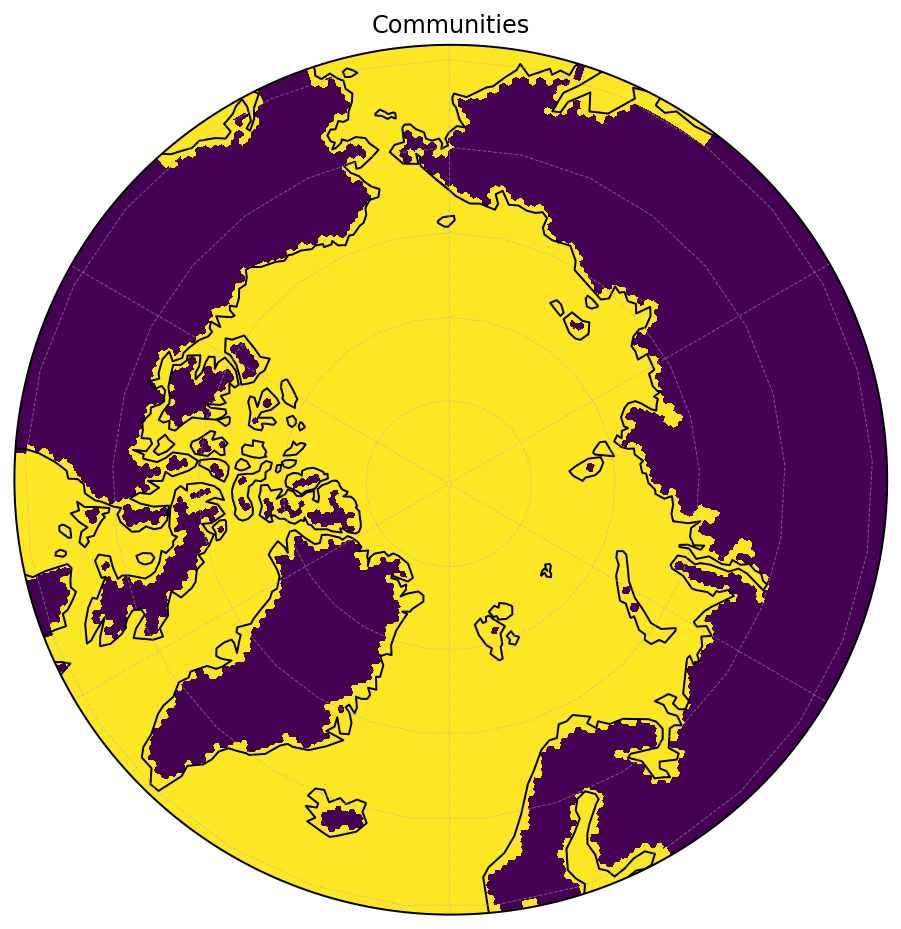

In [172]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.oceanMask[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Communities',
                                             lonRange = (-180, 180),
                                             latRange = (59, 90),
                                             polar = True,
                                             land = False,
                                             cbar = False,
                                             size = (8,8))
ax.pcolormesh(myBins.rimLonBounds, 
              myBins.rimLatBounds, 
              np.expand_dims(myBins.oceanMask[myBins.shiftedRimBindex], 1).T, 
              transform = ccrs.PlateCarree())

In [173]:
with open("oceanMask.pickle", "wb") as maskFile:
    pickle.dump(myBins.oceanMask, maskFile)

In [ ]:
myTrans = transMat.from_pset(psetdir + "pset_Rcmems_Pico11_S1993-5-1_D90_DT20_ODT24.nc", 
                             myBins, 
                             timedelta64 = np.timedelta64(30, 'D'),
                             mask = myBins.oceanMask
                        )

In [193]:
myTrans.save_network("test.net")

In [231]:
myBins.load_communities("test.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(myTrans);
myBins.calculate_global_coherence()
myBins.calculate_mixing(myTrans);
myBins.calculate_global_mixing()

0.32846709943737046

In [232]:
myBins.globalCoherenceRatio

0.8206121412193195

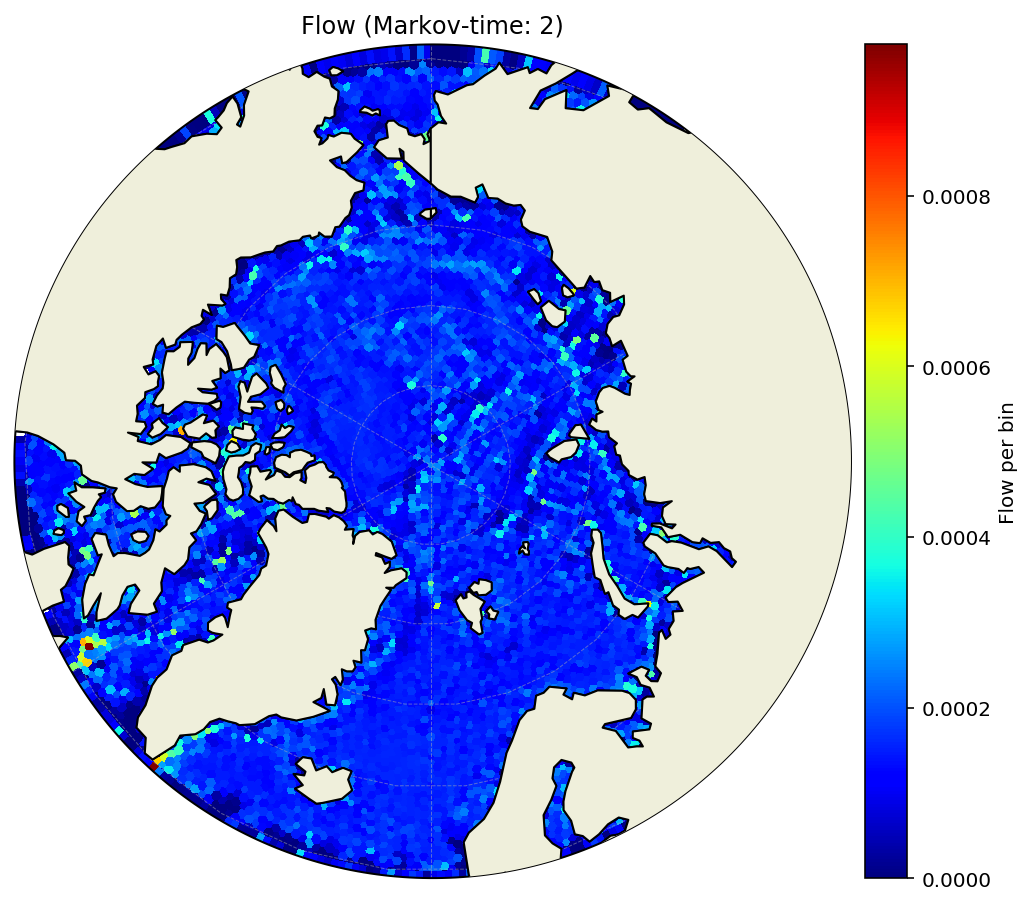

In [236]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.communityFlow[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Flow (Markov-time: 2)',
                                             lonRange = (-180, 180),
                                             latRange = (60, 100),
                                             polar = True,
                                             land = True,
                                             colormap = 'jet',
                                             cbar = True,
                                             units = 'Flow per bin',
                                             size = (8,8))

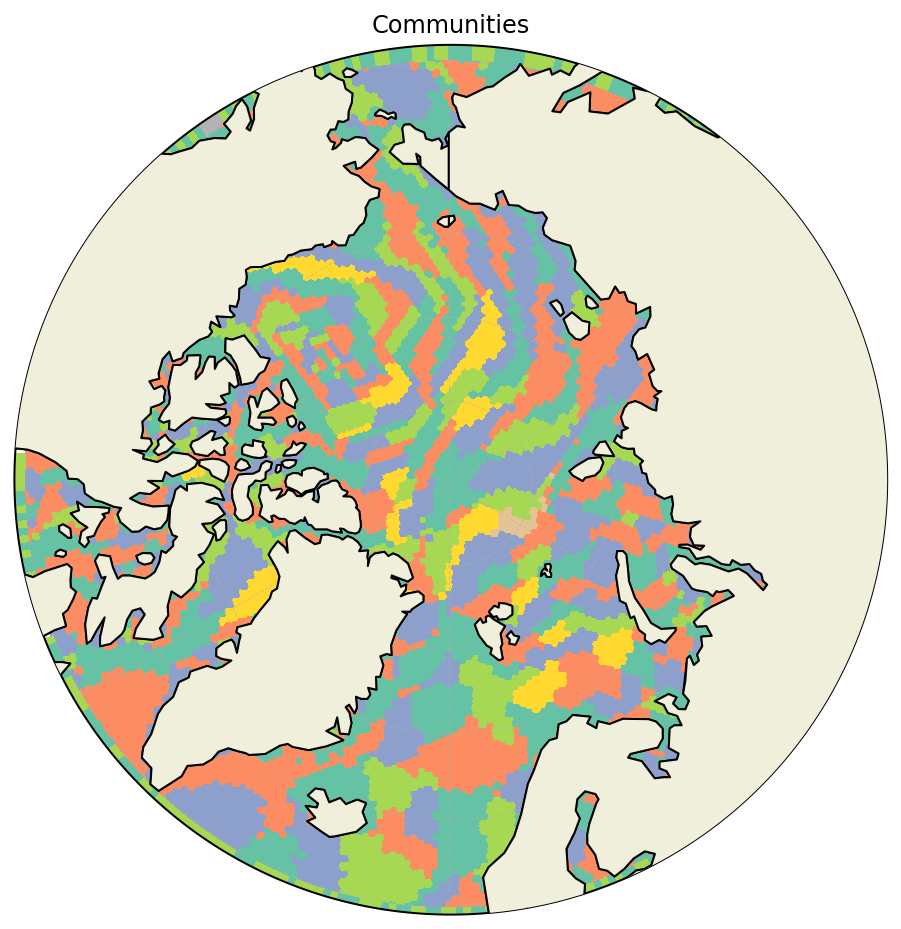

In [238]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Communities',
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             colormap = 'Set2',
                                             cbar = False,
                                             size = (8,8))

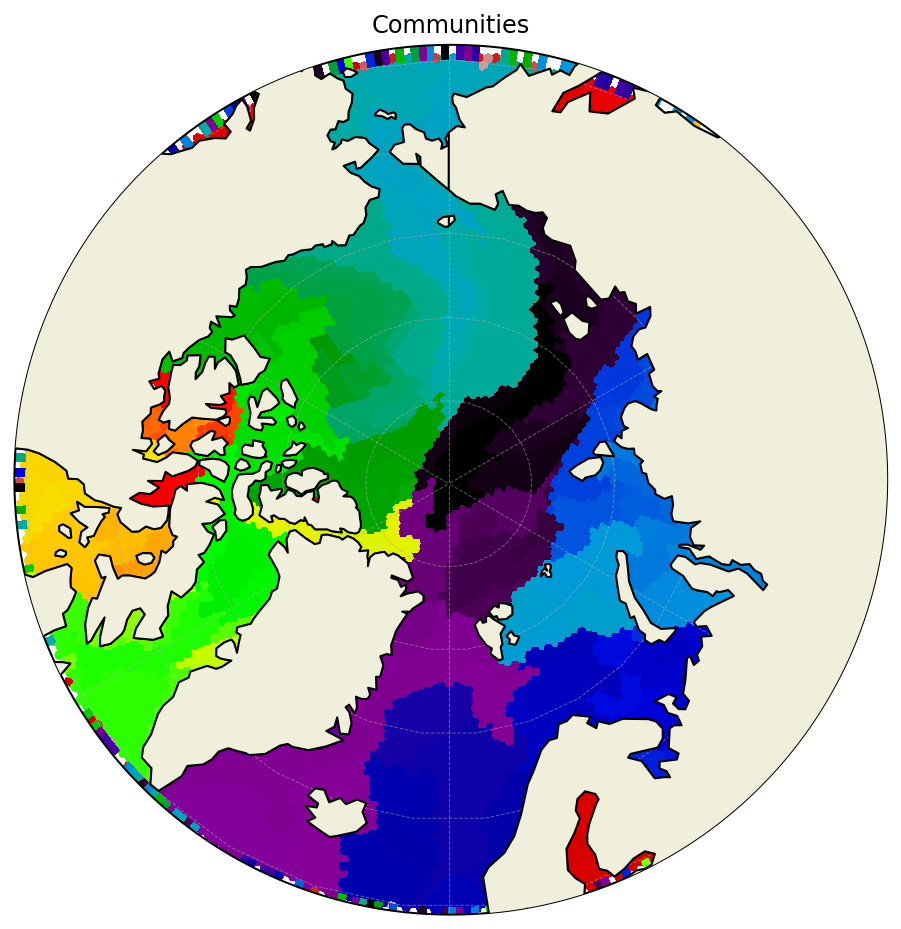

In [255]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.communityID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Communities',
                                             lonRange = (-180, 180),
                                             latRange = (59, 90),
                                             polar = True,
                                             land = True,
                                             colormap = 'nipy_spectral',
                                             cbar = False,
                                             size = (8,8))
ax.pcolormesh(myBins.rimLonBounds,
              myBins.rimLatBounds,
              np.expand_dims(myBins.communityID[myBins.rimBindex], 1).T,
              cmap = 'nipy_spectral',
              vmax = myBins.communityID.max(),
              vmin = myBins.communityID.min(),
              transform = cart.crs.PlateCarree())

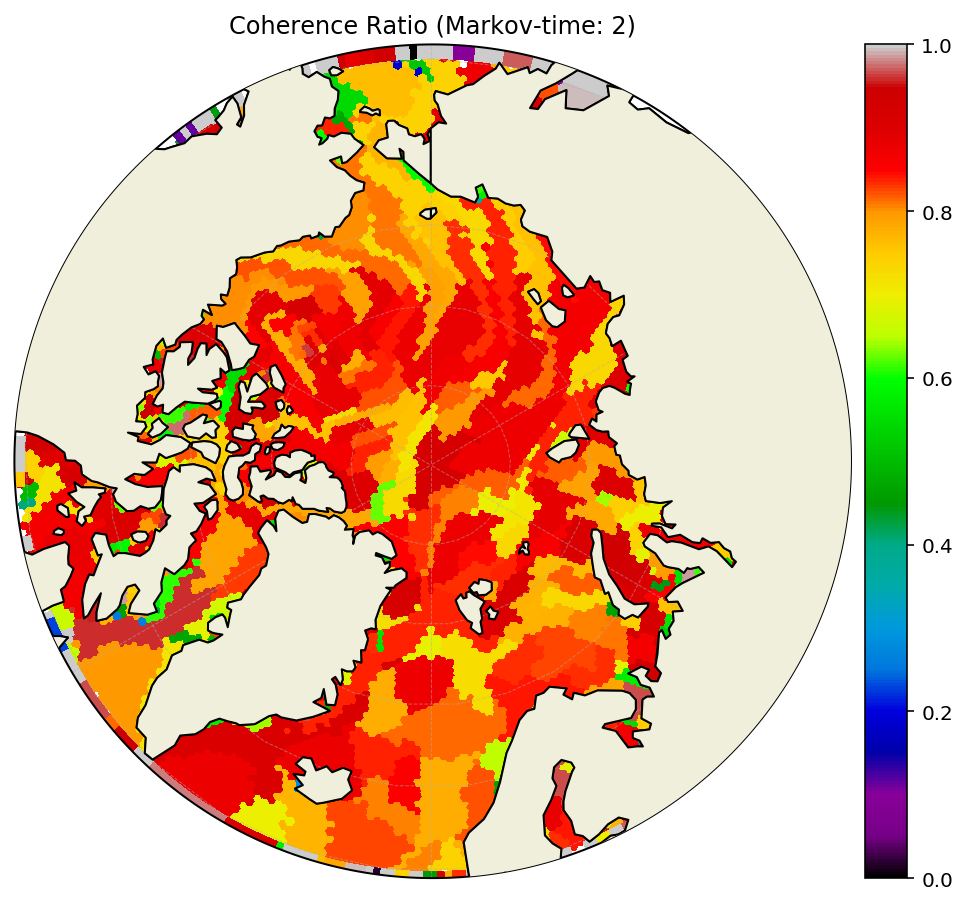

In [242]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Coherence Ratio (Markov-time: 2)',
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             colormap = 'nipy_spectral',
#export = 'communities_Rrcp85_Pico11_S2001-1-1_D90_DT20_ODT24_wedge_Cico7_m2.png',
                                             cbar = True,
                                             size = (8,8))

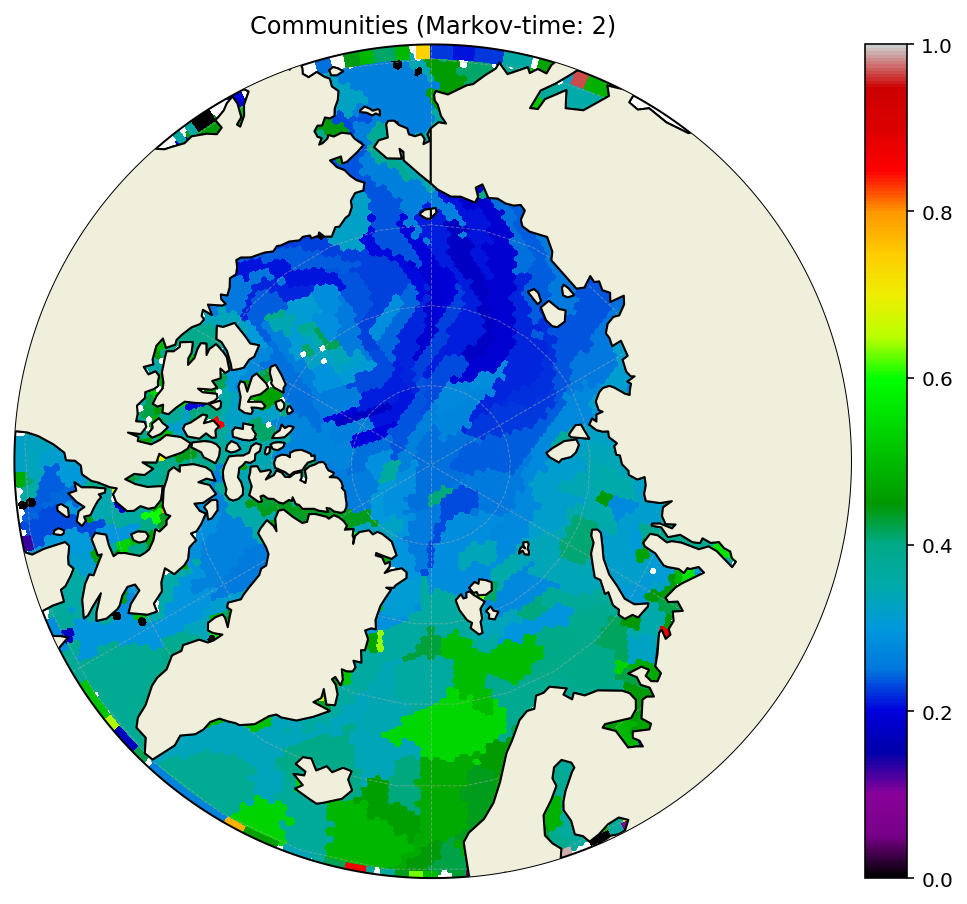

In [245]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Communities (Markov-time: 2)',
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             colormap = 'nipy_spectral',
#export = 'communities_Rrcp85_Pico11_S2001-1-1_D90_DT20_ODT24_wedge_Cico7_m2.png',
                                             cbar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             size = (8,8))

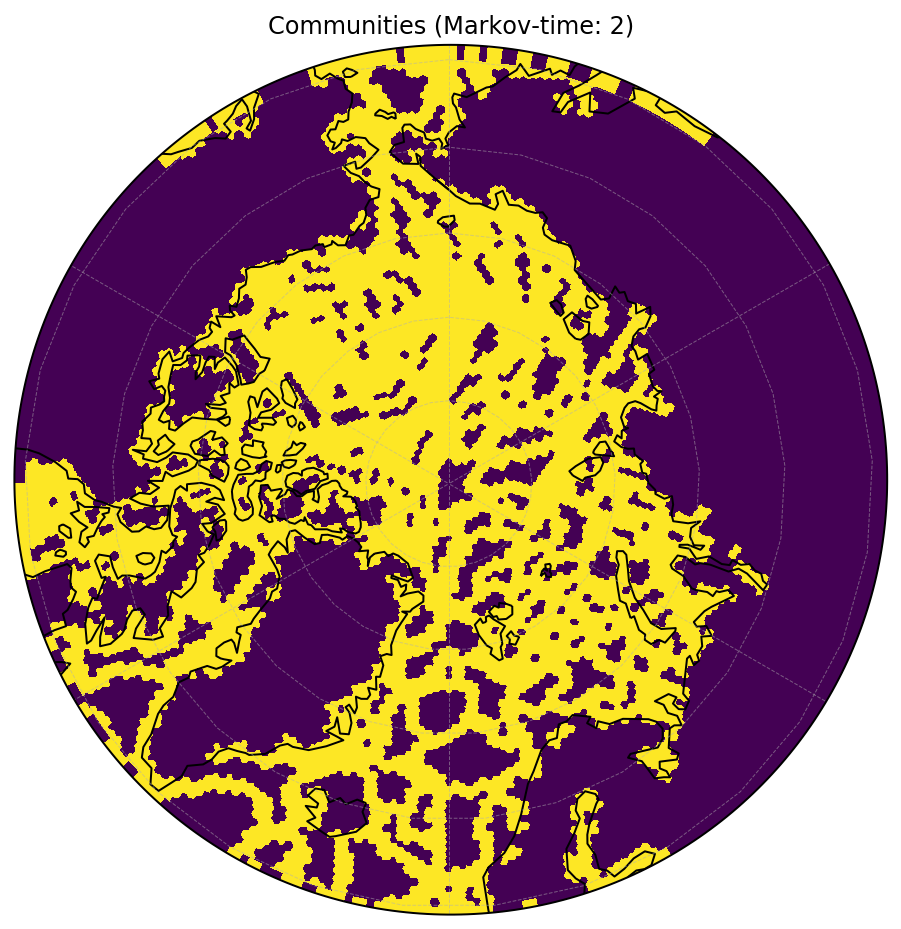

In [244]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask],
                                             myBins.onBoundary[myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             title = 'Communities (Markov-time: 2)',
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             polar = True,
                                             land = False,
#export = 'communities_Rrcp85_Pico11_S2001-1-1_D90_DT20_ODT24_wedge_Cico7_m2.png',
                                             cbar = False,
                                             size = (8,8))